In [ ]:
!pip install transformers peft datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel, PeftConfig
import torch

base_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B", force_download=True, cache_dir="/tmp/huggingface")
base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-0.6B",
    torch_dtype="auto",
    device_map="auto",
    force_download=True,
    cache_dir="/tmp/huggingface"
)

adapter_path = "/content/model"

peft_config = PeftConfig.from_pretrained(adapter_path)
lora_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-0.6B",
    torch_dtype="auto",
    device_map="auto",
    force_download=True,
    cache_dir="/tmp/huggingface"
)
lora_model = PeftModel.from_pretrained(lora_model, adapter_path, config=peft_config)

tokenizer_config.json:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [ ]:
def next_tokens(prompt):
  inputs = base_tokenizer(prompt, return_tensors='pt').to(base_model.device)
  input_ids = inputs["input_ids"]

  with torch.no_grad():
    base_logits = base_model(input_ids).logits[:, -1, :]

  with torch.no_grad():
    lora_logits = lora_model(input_ids).logits[:, -1, :]

  base_top_tokens = torch.topk(base_logits, k=10)
  lora_top_tokens = torch.topk(lora_logits, k=10)

  base_top_text = [base_tokenizer.decode(base_top_token) for base_top_token in base_top_tokens.indices[0]]
  lora_top_text = [base_tokenizer.decode(lora_top_token) for lora_top_token in lora_top_tokens.indices[0]]

  # print("Base model top 10 next tokens:", base_top_text)
  # print("Fine-tuned model top 10 next tokens:", lora_top_text)

  # compute probabilities
  base_probs = F.softmax(base_logits, dim=-1)
  lora_probs = F.softmax(lora_logits, dim=-1)

  base_top_probs = torch.topk(base_probs, k=10).values[0].cpu().tolist()
  lora_top_probs = torch.topk(lora_probs, k=10).values[0].cpu().tolist()

  def plot_token_probs(tokens, probs, title):
      plt.figure(figsize=(12, 4))
      plt.bar(range(len(tokens)), probs)
      plt.xticks(range(len(tokens)), tokens, rotation=90)
      plt.xlabel("Token")
      plt.ylabel("Probability")
      plt.title(title)
      plt.tight_layout()
      plt.show()

  plot_token_probs(base_top_text, base_top_probs, "Base model top 10 token probabilities")

  plot_token_probs(lora_top_text, lora_top_probs, "Fine tuned top 10 token probabilities")


In [ ]:
def generate(model, instruction):
  tokenizer = base_tokenizer

  model_inputs = base_tokenizer(prompt, return_tensors='pt').to(model.device)

  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=128
  )
  output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

  try:
      index = len(output_ids) - output_ids[::-1].index(151668)
  except ValueError:
      index = 0

  output = tokenizer.decode(output_ids[index:], skip_special_tokens=False)

  print(output)

In [ ]:
def test_prompt(prompt):
  print("next tokens")
  next_tokens(prompt)

  print("base model")
  generate(base_model, prompt)

  print("fine tuned model")
  generate(lora_model, prompt)

next tokens


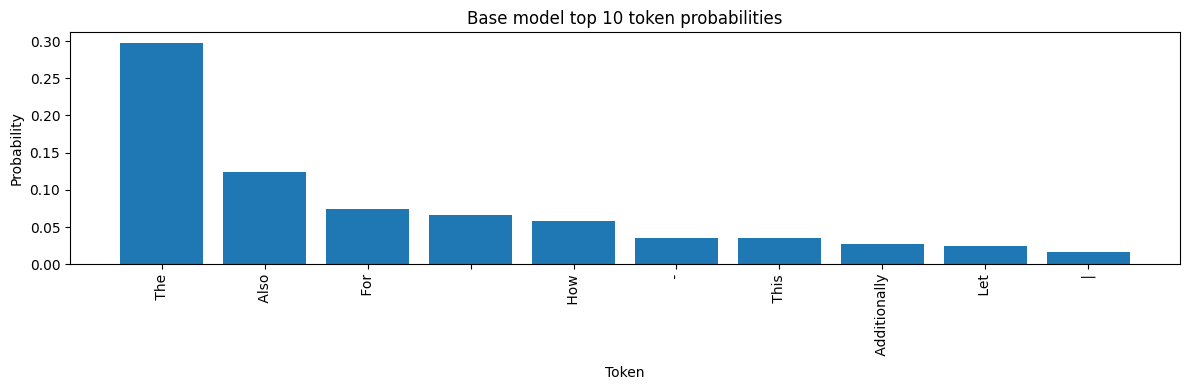

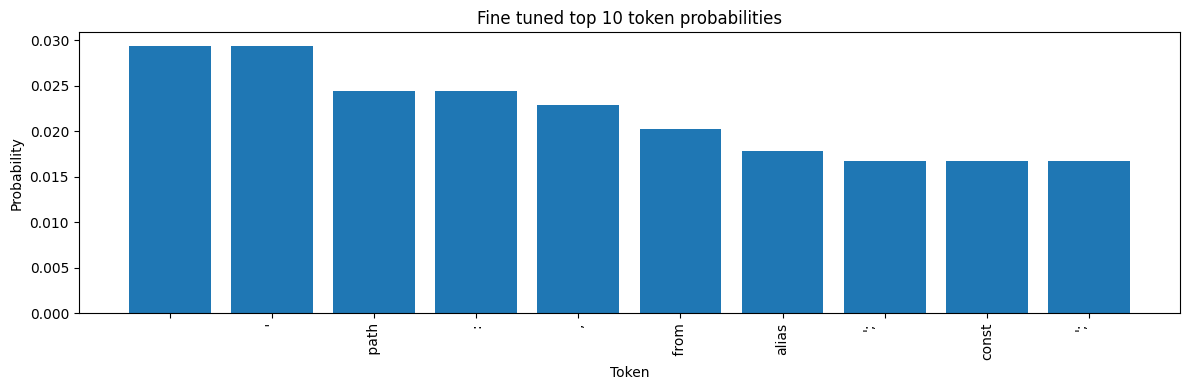

base model
 The code should allow users to specify the directory path to use when accessing the file system, and should not require the user to provide a password. Also, the code should display a message that informs the user that the alias is set up successfully. Additionally, the code should have a function that handles the alias setup process.

Okay, let's see. I need to create a Python script that uses the path module to set up aliases for directories. The user can specify the directory path, and the code should not require a password. Also, there should be a function to handle the alias setup. Let me break this down step by step.


fine tuned model
';

 aliases:,
 ',
',
',
';
 path alias',
';
 aliases',
  the the  1 ,     ',',
',
   ',
   ',
',
 ',   : ',',
        path',
',
 path  ',',  ',
 path',
alias  ',
  path ',
 ,    ',
    ',
 ',
',
  path    ',
    alias: ',
 :',
   alias ',
 alias  ',',
  alias  ',
 path',
 ',
    path    path',
  alias',
 alias    alias ',
 alias alias 

In [ ]:
test_prompt('Generate code that sets up aliases for different directories using the path module from the "path" package.')

next tokens


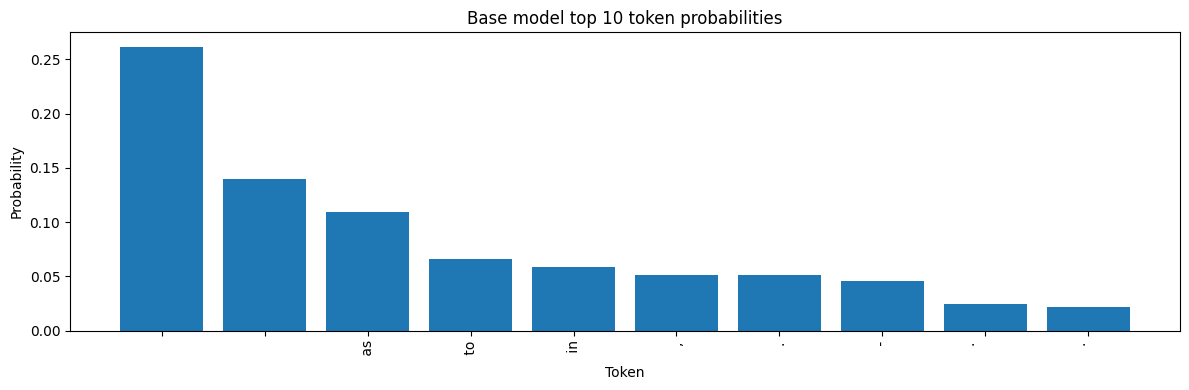

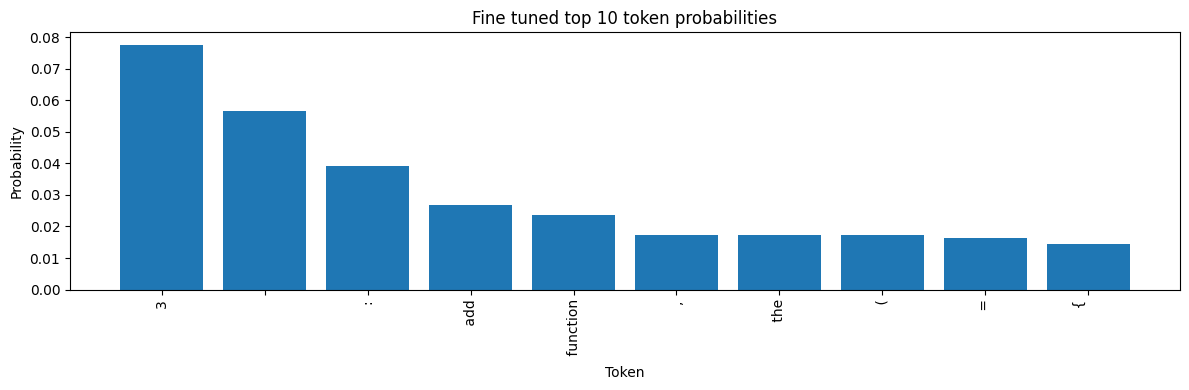

base model
 The code should allow for multiple directories to be set, and each alias should point to a different directory. Also, the code should allow for multiple directories to be set in the same directory, and each alias should point to a different directory. Additionally, the code should allow for the use of a single directory and point to it as an alias. The code should also allow for the use of multiple directories, each pointing to a different directory, and the code should allow for the use of a single directory and point to it as an alias. The code should also allow for the use of multiple directories, each pointing to a different directory, and
fine tuned model
';
: from:',
    path';
:',
 alias: {
 alias',
 alias',
 alias',
 aliasalias fromalias alias aliasalias aliasalias alias aliasalias alias alias aliasalias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias alias aliasaliasalias alias alias alia

In [ ]:
test_prompt('write a function which adds 3 numbers and returns the result')